In [ ]:
%pip install pandas numpy scipy scikit-learn matplotlib tensorflow rainflow seaborn

In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.stats import skew, kurtosis
from rainflow import count_cycles
from statsmodels.tsa.seasonal import STL

# Configuration
SENSOR_FILES = ['data_acquire_data_2DHRT_Pitch_15-03-26-40.csv', 'data_acquire_data_2DHRT_Roll_15-03-26-40.csv', 'data_acquire_data_Displacement_15-03-48-94.csv', 'data_acquire_data_Strain-xx-high_rate_15-03-52-24.csv']
OUTPUT_FILE = "preprocessed_features.csv"  # File to save the feature-engineered data
RESAMPLE_INTERVAL = '5min'  # 5-minute intervals

# Function to load and process a single file
def process_file(file_path):
    df = pd.read_csv(file_path)
    value_column = [col for col in df.columns if col.lower() != 'time'][0]
    df['Time'] = pd.to_datetime(df['Time'], unit='s')
    df.set_index('Time', inplace=True)
    df = df.resample(RESAMPLE_INTERVAL).mean()
    z_scores = (df[value_column] - df[value_column].mean()) / df[value_column].std()
    df = df[np.abs(z_scores) < 3]

    def butter_lowpass_filter(data, cutoff=0.1, fs=1.0, order=2):
        nyquist = 0.5 * fs
        normal_cutoff = cutoff / nyquist
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return filtfilt(b, a, data)

    df[value_column] = butter_lowpass_filter(df[value_column].fillna(0), cutoff=0.1, fs=1.0)
    return df

# Generate basic statistical features
def generate_statistical_features(df):
    features = pd.DataFrame(index=df.index)
    features['mean'] = df.mean(axis=1)
    features['std'] = df.std(axis=1)
    features['skew'] = df.apply(skew, axis=1)
    features['kurtosis'] = df.apply(kurtosis, axis=1)
    return features

# Generate dynamic rolling features
def generate_dynamic_features(df, window_size=12):
    features = pd.DataFrame(index=df.index)
    features['rolling_mean'] = df.rolling(window=window_size).mean().mean(axis=1)
    features['rolling_std'] = df.rolling(window=window_size).std().mean(axis=1)
    features['rolling_min'] = df.rolling(window=window_size).min().mean(axis=1)
    features['rolling_max'] = df.rolling(window=window_size).max().mean(axis=1)
    return features

# Compute correlation features
def generate_correlation_features(df):
    features = pd.DataFrame(index=df.index)
    corr_matrix = df.corr()
    for i, col1 in enumerate(df.columns):
        for j, col2 in enumerate(df.columns):
            if i < j:
                features[f'{col1}_vs_{col2}_corr'] = df[col1].rolling(12).corr(df[col2])
    return features

# Apply Rainflow Counting
def generate_rainflow_features(df):
    features = pd.DataFrame(index=df.index)
    for col in df.columns:
        cycles = count_cycles(df[col].dropna().values)
        features[f'{col}_rainflow_mean'] = np.mean([cycle[0] for cycle in cycles])
        features[f'{col}_rainflow_count'] = len(cycles)
    return features

# Apply STL Decomposition
def generate_stl_features(df):
    features = pd.DataFrame(index=df.index)
    # Calculate the period based on resampling interval
    period = int(24 * 60 / pd.Timedelta(RESAMPLE_INTERVAL).seconds / 60) # Assuming daily cycle

    # Ensure period is at least 2
    period = max(2, period)

    for col in df.columns:
        # Pass the calculated period to the STL function
        stl = STL(df[col].dropna(), period=period, seasonal=13)
        result = stl.fit()
        features[f'{col}_trend'] = result.trend
        features[f'{col}_seasonal'] = result.seasonal
        features[f'{col}_residual'] = result.resid
    return features

# Main processing loop
processed_dfs = []
for file in SENSOR_FILES:
    processed_df = process_file(file)
    processed_dfs.append(processed_df)

merged_data = pd.concat(processed_dfs, axis=1)
merged_data.columns = [f"Sensor_{i+1}" for i in range(len(processed_dfs))]
merged_data.dropna(inplace=True)

# Generate features
statistical_features = generate_statistical_features(merged_data)
dynamic_features = generate_dynamic_features(merged_data)
correlation_features = generate_correlation_features(merged_data)
rainflow_features = generate_rainflow_features(merged_data)
stl_features = generate_stl_features(merged_data)

# Combine all features
all_features = pd.concat([statistical_features, dynamic_features, correlation_features, rainflow_features, stl_features], axis=1)
all_features.dropna(inplace=True)

# Save features to file
all_features.to_csv(OUTPUT_FILE)
print(f"Feature engineering complete. Features saved to {OUTPUT_FILE}")


Feature engineering complete. Features saved to preprocessed_features.csv


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0973 - val_loss: 0.0333
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0294 - val_loss: 0.0160
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0177 - val_loss: 0.0098
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0126 - val_loss: 0.0085
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0106 - val_loss: 0.0060
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082 - val_loss: 0.0050
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071 - val_loss: 0.0046
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - val_loss: 0.0041
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - val_loss: 0.0036
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - val_loss: 0.0033
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050 - val_loss: 0.0031
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046 - val_loss: 0.0029

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.8943e-04
Test Loss: 0.0010050407145172358


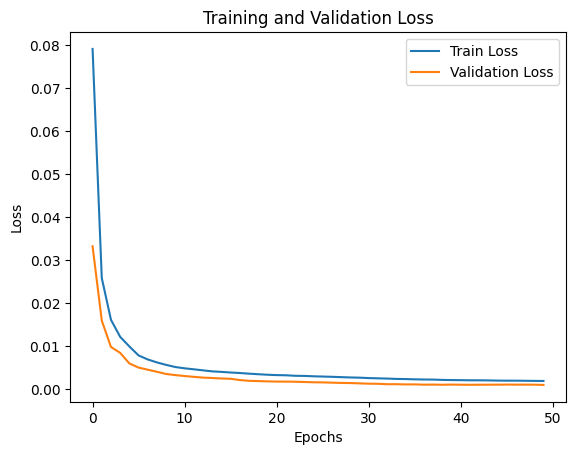

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Anomaly Detection Threshold: 0.003215434844592203
Number of anomalies detected: 314


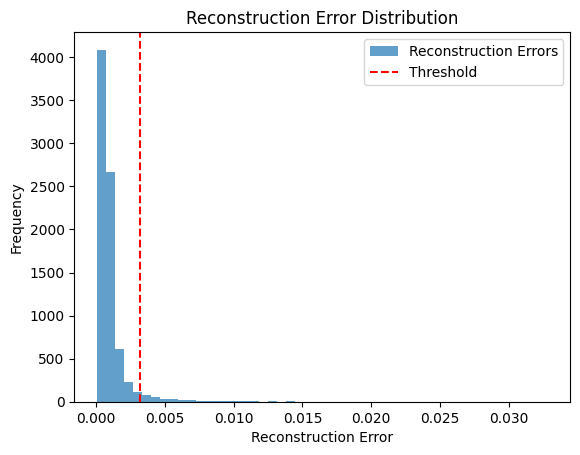

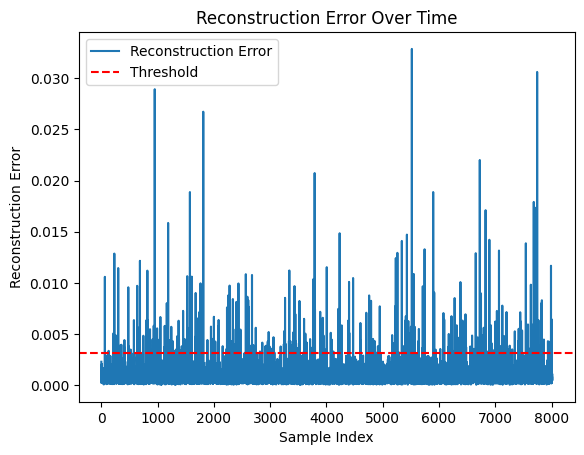

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Configuration
INPUT_FILE = "preprocessed_features.csv"  # File containing the feature-engineered data
EPOCHS = 50  # Number of training epochs
BATCH_SIZE = 1024  # Batch size for training
TEST_SIZE = 0.2  # Proportion of the dataset to include in the test split
VALIDATION_SPLIT = 0.1  # Proportion of training data for validation
THRESHOLD_FACTOR = 1.5  # Factor to scale the threshold for anomaly detection

# Load preprocessed features
data = pd.read_csv(INPUT_FILE, index_col=0)  # Load feature-engineered data from a CSV file

# Scale the data to [0, 1] range
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Split data into training and testing sets
X_train, X_test = train_test_split(data_scaled, test_size=TEST_SIZE, random_state=42)

# Define Autoencoder model
input_dim = X_train.shape[1]
model = Sequential([
    Dense(64, activation='relu', input_dim=input_dim),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(input_dim, activation='sigmoid')
])

model.compile(optimizer='adam', loss='mse')

# Train the Autoencoder
history = model.fit(
    X_train, X_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    shuffle=True
)

# Save the trained model
model.save("autoencoder_anomaly_detector.h5")

# Evaluate the model on the test set
loss = model.evaluate(X_test, X_test)
print(f"Test Loss: {loss}")

# Visualize training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Anomaly Detection: Reconstruction Errors
reconstructions = model.predict(X_test)
reconstruction_errors = np.mean(np.square(X_test - reconstructions), axis=1)

# Determine anomaly threshold
threshold = np.mean(reconstruction_errors) + THRESHOLD_FACTOR * np.std(reconstruction_errors)
print(f"Anomaly Detection Threshold: {threshold}")

# Classify anomalies based on the threshold
anomalies = reconstruction_errors > threshold
print(f"Number of anomalies detected: {np.sum(anomalies)}")

# Visualization 1: Reconstruction Error Distribution
plt.hist(reconstruction_errors, bins=50, alpha=0.7, label='Reconstruction Errors')
plt.axvline(x=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.show()

# Visualization 2: Reconstruction Error over Time
plt.plot(range(len(reconstruction_errors)), reconstruction_errors, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error Over Time')
plt.legend()
plt.show()

1002/1002 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


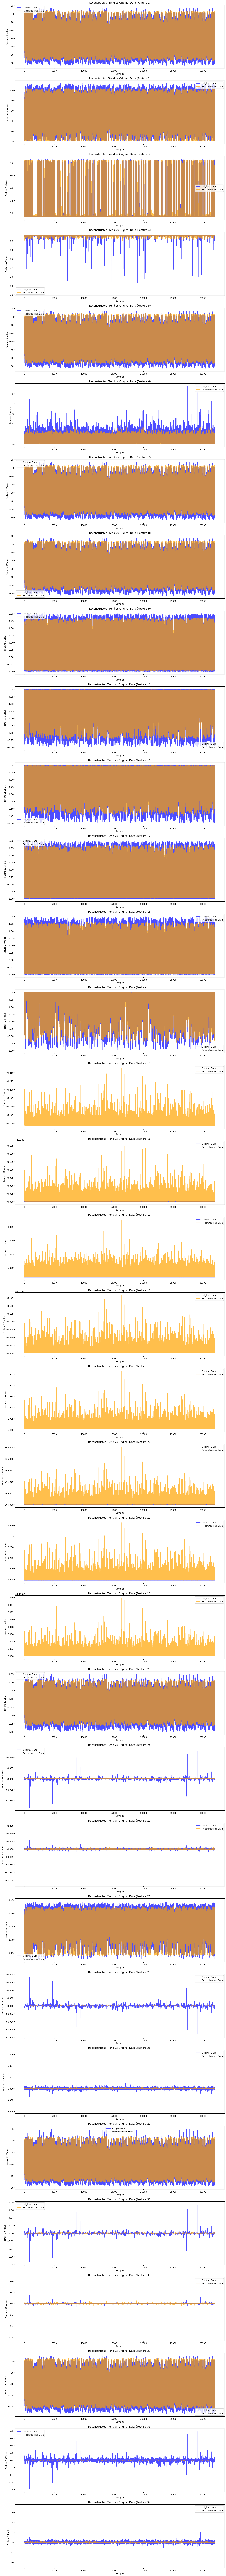

In [ ]:
# Visualize reconstructed trend vs original data for all features in the training set
X_train_reconstructed = model.predict(X_train)

# Reverse the scaling for better interpretability
X_train_original = scaler.inverse_transform(X_train)
X_train_reconstructed_original = scaler.inverse_transform(X_train_reconstructed)

# Create a plot for each feature
num_features = X_train_original.shape[1]

# Set up a figure with subplots
plt.figure(figsize=(15, 5 * num_features))

# Loop through each feature and generate a subplot
for feature_idx in range(num_features):
    plt.subplot(num_features, 1, feature_idx + 1)  # Create a subplot for each feature
    plt.plot(
        range(len(X_train_original)),
        X_train_original[:, feature_idx],
        label='Original Data',
        alpha=0.7,
        color='blue'
    )
    plt.plot(
        range(len(X_train_reconstructed_original)),
        X_train_reconstructed_original[:, feature_idx],
        label='Reconstructed Data',
        alpha=0.7,
        color='orange'
    )
    plt.xlabel('Samples')
    plt.ylabel(f'Feature {feature_idx + 1} Value')
    plt.title(f'Reconstructed Trend vs Original Data (Feature {feature_idx + 1})')
    plt.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


1252/1252 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Anomaly Detection Threshold: 1.7153420356489455
Number of anomalies detected: 180


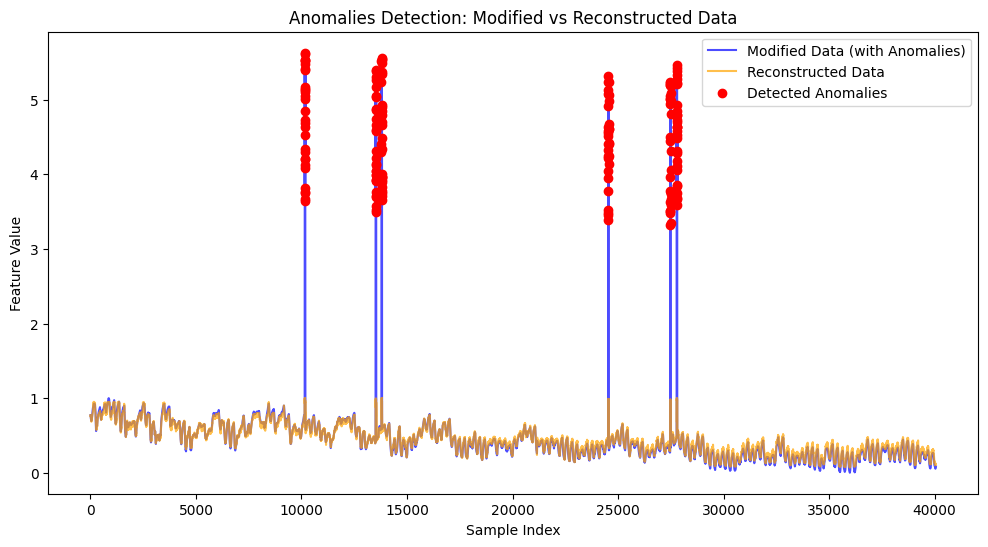

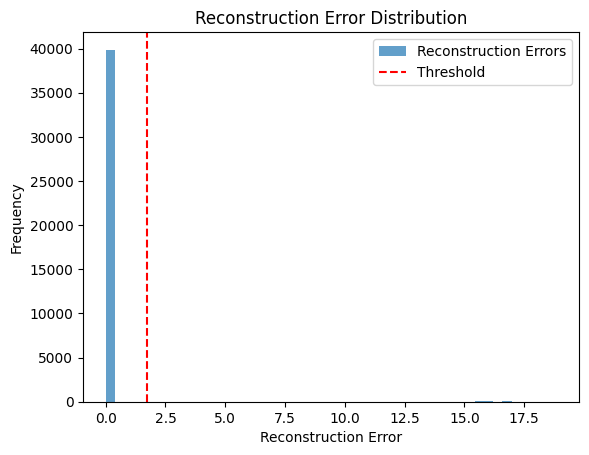

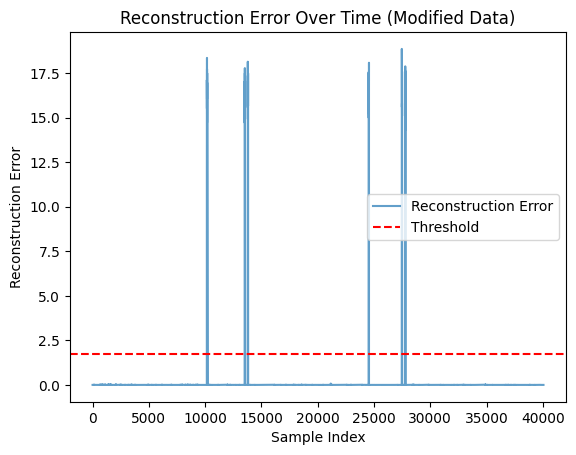

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Configuration
INPUT_FILE = "preprocessed_features.csv"  # File containing the feature-engineered data
THRESHOLD_FACTOR = 1.5  # Factor to scale the threshold for anomaly detection
ANOMALY_DURATION = 30  # Duration of anomalies in terms of time steps
ANOMALY_MAGNITUDE = 3  # Magnitude of the anomaly spikes

# Load preprocessed features
data = pd.read_csv(INPUT_FILE, index_col=0)  # Load feature-engineered data from a CSV file

# Scale the data to [0, 1] range
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Split data into training and testing sets
X_train = data_scaled  # Use the entire dataset as training data to introduce anomalies
X_test = X_train  # In this case, we simulate anomalies in the training set itself

# Introduce time-based anomalies into the training data (spikes that happen over time)
num_anomalies = 6  # Number of anomaly events to create
for _ in range(num_anomalies):
    anomaly_start = np.random.randint(0, len(X_train) - ANOMALY_DURATION)  # Randomly select a start time
    anomaly_end = anomaly_start + ANOMALY_DURATION  # Define the end of the anomaly duration

    # Create spikes (anomalies) for a range of features
    anomaly_spike = np.random.uniform(ANOMALY_MAGNITUDE, ANOMALY_MAGNITUDE + 2, (anomaly_end - anomaly_start, X_train.shape[1]))

    # Add anomalies to the data (simulating spikes over time)
    X_train[anomaly_start:anomaly_end] += anomaly_spike

# Define the Autoencoder model (Assuming the model is already trained)
model = tf.keras.models.load_model("autoencoder_anomaly_detector.h5", compile=False)
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

# Get the reconstructed data from the autoencoder
X_train_reconstructed = model.predict(X_train)

# Calculate reconstruction errors
reconstruction_errors = np.mean(np.square(X_train - X_train_reconstructed), axis=1)

# Determine anomaly threshold
threshold = np.mean(reconstruction_errors) + THRESHOLD_FACTOR * np.std(reconstruction_errors)
print(f"Anomaly Detection Threshold: {threshold}")

# Classify anomalies based on the threshold
anomalies = reconstruction_errors > threshold
print(f"Number of anomalies detected: {np.sum(anomalies)}")

# Visualization 1: Compare original, reconstructed, and modified data for the first feature
plt.figure(figsize=(12, 6))
plt.plot(range(len(X_train)), X_train[:, 0], label='Modified Data (with Anomalies)', alpha=0.7, color='blue')
plt.plot(range(len(X_train_reconstructed)), X_train_reconstructed[:, 0], label='Reconstructed Data', alpha=0.7, color='orange')

# Highlight anomalies in the modified data
plt.scatter(np.where(anomalies)[0], X_train[anomalies, 0], color='red', label='Detected Anomalies', zorder=5)

plt.xlabel('Sample Index')
plt.ylabel('Feature Value')
plt.title('Anomalies Detection: Modified vs Reconstructed Data')
plt.legend()
plt.show()

# Visualization 2: Reconstruction Error Distribution
plt.hist(reconstruction_errors, bins=50, alpha=0.7, label='Reconstruction Errors')
plt.axvline(x=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.show()

# Visualization 3: Reconstruction Error Over Time (Modified Data)
plt.plot(range(len(reconstruction_errors)), reconstruction_errors, label='Reconstruction Error', alpha=0.7)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error Over Time (Modified Data)')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.stats import skew, kurtosis
from rainflow import count_cycles
from statsmodels.tsa.seasonal import STL

# Configuration
SENSOR_FILES = ['data_acquire_data_2DHRT_Pitch_15-03-25-14.csv', 'data_acquire_data_2DHRT_Roll_15-03-25-14.csv', 'data_acquire_data_Displacement_15-03-50-06.csv', 'data_acquire_data_Strain-xx-high_rate_15-03-52-24.csv']
OUTPUT_FILE = "preprocessed_features_test.csv"  # File to save the feature-engineered data
RESAMPLE_INTERVAL = '5min'  # 5-minute intervals

# Function to load and process a single file
def process_file(file_path):
    df = pd.read_csv(file_path)
    value_column = [col for col in df.columns if col.lower() != 'time'][0]
    df['Time'] = pd.to_datetime(df['Time'], unit='s')
    df.set_index('Time', inplace=True)
    df = df.resample(RESAMPLE_INTERVAL).mean()
    z_scores = (df[value_column] - df[value_column].mean()) / df[value_column].std()
    df = df[np.abs(z_scores) < 3]

    def butter_lowpass_filter(data, cutoff=0.1, fs=1.0, order=2):
        nyquist = 0.5 * fs
        normal_cutoff = cutoff / nyquist
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return filtfilt(b, a, data)

    df[value_column] = butter_lowpass_filter(df[value_column].fillna(0), cutoff=0.1, fs=1.0)
    return df

# Generate basic statistical features
def generate_statistical_features(df):
    features = pd.DataFrame(index=df.index)
    features['mean'] = df.mean(axis=1)
    features['std'] = df.std(axis=1)
    features['skew'] = df.apply(skew, axis=1)
    features['kurtosis'] = df.apply(kurtosis, axis=1)
    return features

# Generate dynamic rolling features
def generate_dynamic_features(df, window_size=12):
    features = pd.DataFrame(index=df.index)
    features['rolling_mean'] = df.rolling(window=window_size).mean().mean(axis=1)
    features['rolling_std'] = df.rolling(window=window_size).std().mean(axis=1)
    features['rolling_min'] = df.rolling(window=window_size).min().mean(axis=1)
    features['rolling_max'] = df.rolling(window=window_size).max().mean(axis=1)
    return features

# Compute correlation features
def generate_correlation_features(df):
    features = pd.DataFrame(index=df.index)
    corr_matrix = df.corr()
    for i, col1 in enumerate(df.columns):
        for j, col2 in enumerate(df.columns):
            if i < j:
                features[f'{col1}_vs_{col2}_corr'] = df[col1].rolling(12).corr(df[col2])
    return features

# Apply Rainflow Counting
def generate_rainflow_features(df):
    features = pd.DataFrame(index=df.index)
    for col in df.columns:
        cycles = count_cycles(df[col].dropna().values)
        features[f'{col}_rainflow_mean'] = np.mean([cycle[0] for cycle in cycles])
        features[f'{col}_rainflow_count'] = len(cycles)
    return features

# Apply STL Decomposition
def generate_stl_features(df):
    features = pd.DataFrame(index=df.index)
    # Calculate the period based on resampling interval
    period = int(24 * 60 / pd.Timedelta(RESAMPLE_INTERVAL).seconds / 60) # Assuming daily cycle

    # Ensure period is at least 2
    period = max(2, period)

    for col in df.columns:
        # Pass the calculated period to the STL function
        stl = STL(df[col].dropna(), period=period, seasonal=13)
        result = stl.fit()
        features[f'{col}_trend'] = result.trend
        features[f'{col}_seasonal'] = result.seasonal
        features[f'{col}_residual'] = result.resid
    return features

# Main processing loop
processed_dfs = []
for file in SENSOR_FILES:
    processed_df = process_file(file)
    processed_dfs.append(processed_df)

merged_data = pd.concat(processed_dfs, axis=1)
merged_data.columns = [f"Sensor_{i+1}" for i in range(len(processed_dfs))]
merged_data.dropna(inplace=True)

# Generate features
statistical_features = generate_statistical_features(merged_data)
dynamic_features = generate_dynamic_features(merged_data)
correlation_features = generate_correlation_features(merged_data)
rainflow_features = generate_rainflow_features(merged_data)
stl_features = generate_stl_features(merged_data)

# Combine all features
all_features = pd.concat([statistical_features, dynamic_features, correlation_features, rainflow_features, stl_features], axis=1)
all_features.dropna(inplace=True)

# Save features to file
all_features.to_csv(OUTPUT_FILE)
print(f"Feature engineering complete. Features saved to {OUTPUT_FILE}")


Feature engineering complete. Features saved to preprocessed_features_test.csv


1227/1227 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Anomaly Detection Threshold: 10384.176790794863
Number of anomalies detected: 0


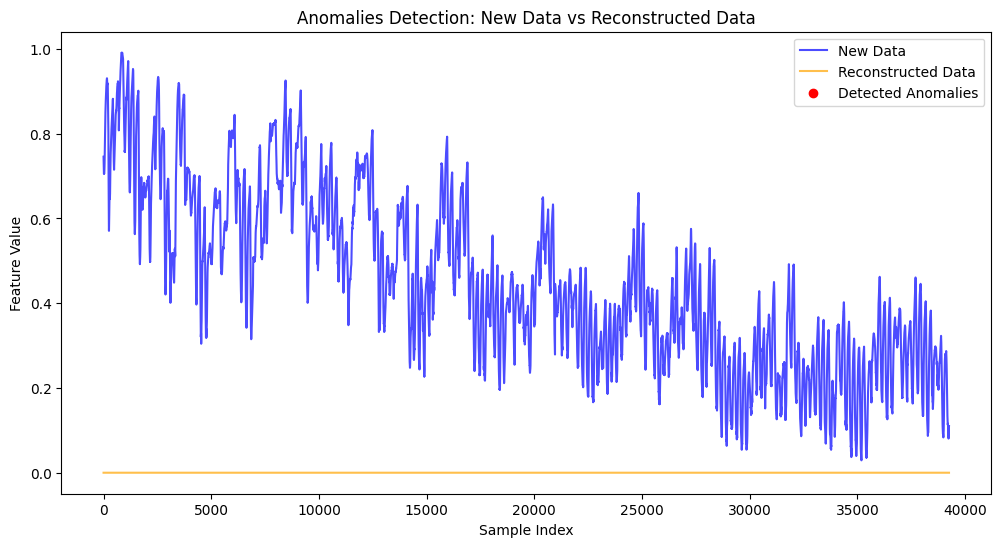

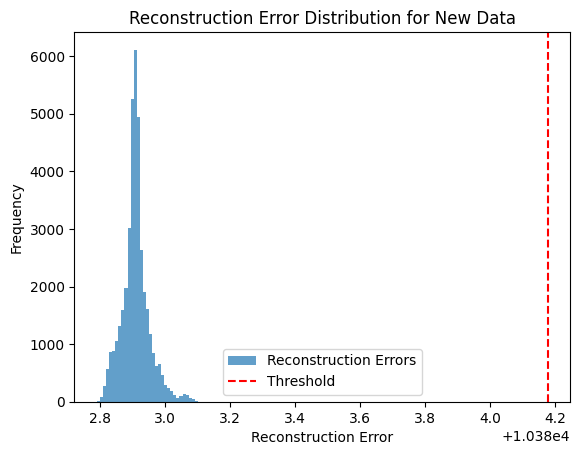

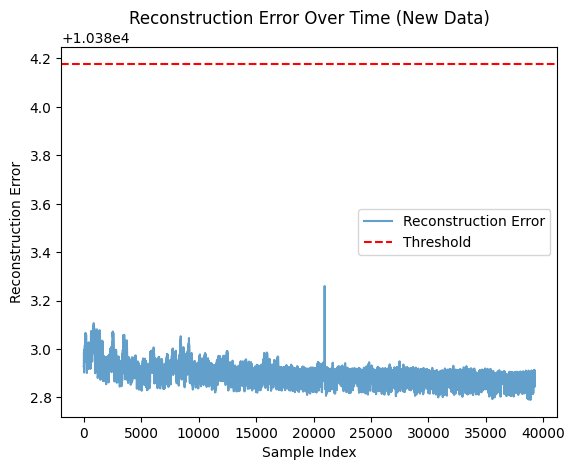

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Configuration
INPUT_FILE = "preprocessed_features_test.csv"  # File containing the new data to test the model on
THRESHOLD_FACTOR = 30  # Factor to scale the threshold for anomaly detection

# Load the new data
new_data = pd.read_csv(INPUT_FILE, index_col=0)  # Assuming the data has a Time column as the index

# Scale the new data using the same scaler that was used for the training data
new_data_scaled = scaler.transform(new_data)  # Use the same scaler to scale new data

# Define the Autoencoder model (Assuming the model is already trained)
model = tf.keras.models.load_model("autoencoder_anomaly_detector.h5", compile=False)
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

# Get the reconstructed data from the autoencoder
new_data_reconstructed = model.predict(new_data_scaled)

# Calculate reconstruction errors
reconstruction_errors = np.mean(np.square(new_data_scaled - new_data_reconstructed), axis=1)

# Determine anomaly threshold
threshold = np.mean(reconstruction_errors) + THRESHOLD_FACTOR * np.std(reconstruction_errors)
print(f"Anomaly Detection Threshold: {threshold}")

# Classify anomalies based on the threshold
anomalies = reconstruction_errors > threshold
print(f"Number of anomalies detected: {np.sum(anomalies)}")

# Visualization 1: Compare original, reconstructed, and new data for the first feature
plt.figure(figsize=(12, 6))
plt.plot(range(len(new_data_scaled)), new_data_scaled[:, 0], label='New Data', alpha=0.7, color='blue')
plt.plot(range(len(new_data_reconstructed)), new_data_reconstructed[:, 0], label='Reconstructed Data', alpha=0.7, color='orange')

# Highlight anomalies in the new data
plt.scatter(np.where(anomalies)[0], new_data_scaled[anomalies, 0], color='red', label='Detected Anomalies', zorder=5)

plt.xlabel('Sample Index')
plt.ylabel('Feature Value')
plt.title('Anomalies Detection: New Data vs Reconstructed Data')
plt.legend()
plt.show()

# Visualization 2: Reconstruction Error Distribution for New Data
plt.hist(reconstruction_errors, bins=50, alpha=0.7, label='Reconstruction Errors')
plt.axvline(x=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution for New Data')
plt.legend()
plt.show()

# Visualization 3: Reconstruction Error Over Time (New Data)
plt.plot(range(len(reconstruction_errors)), reconstruction_errors, label='Reconstruction Error', alpha=0.7)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error Over Time (New Data)')
plt.legend()
plt.show()
